In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import string
import random
import re

from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Import Data

In [2]:
df_data = pd.read_csv('../data/data_raw.csv')

df_data.head() 

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


# EDA

In [101]:
print(df_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53044 entries, 0 to 53043
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53042 non-null  object
dtypes: object(2)
memory usage: 828.9+ KB
None


In [102]:
df_data.dtypes

statement    object
status       object
dtype: object

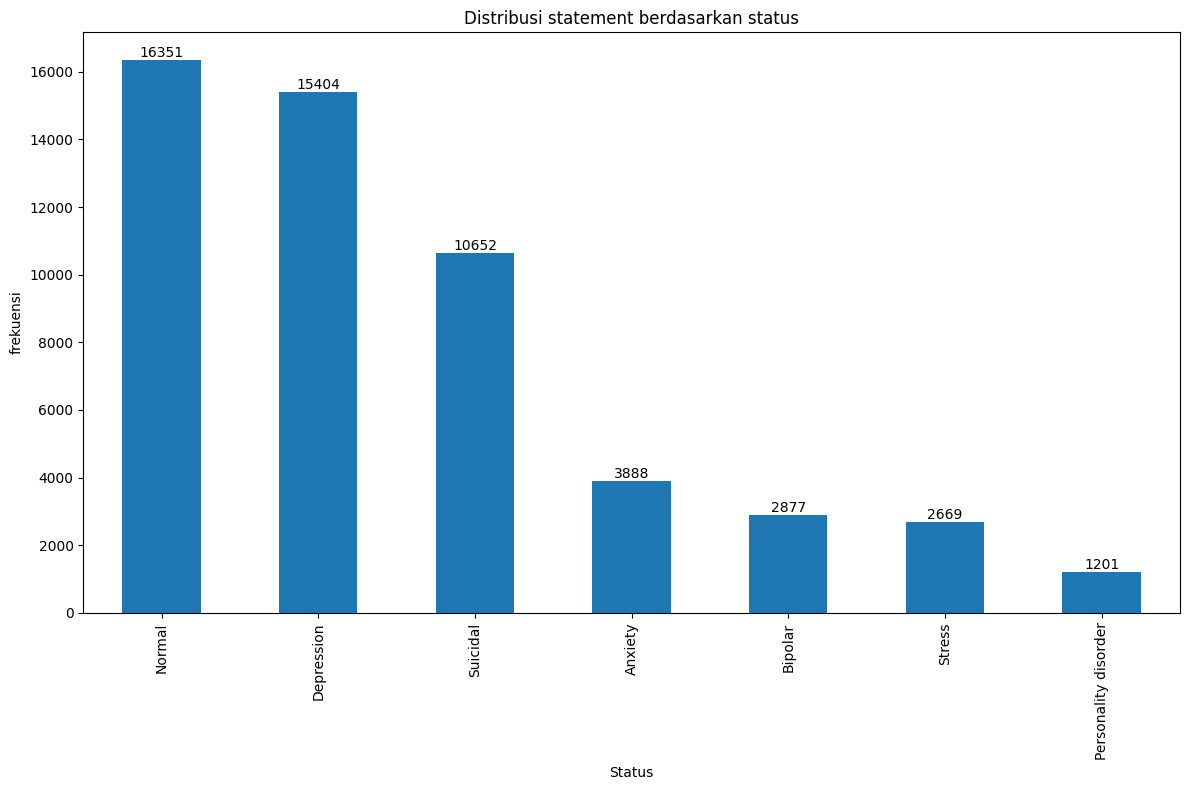

In [103]:
plt.figure(figsize=(12,8))

# get the unique status values and their counts
status_counts = df_data['status'].value_counts()

# create the bar plot
ax = status_counts.plot(kind='bar')

# add the count labels on top of each bar
for i, v in enumerate(status_counts):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.title('Distribusi statement berdasarkan status')
plt.xlabel('Status')
plt.ylabel('frekuensi')
plt.tight_layout()
plt.show() 

# Prepos

In [104]:
df_data.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [105]:
df_data.shape

(53044, 2)

### Reduce Data

In [106]:
# Data kosong
df_data.isnull().sum()

statement    363
status         2
dtype: int64

In [107]:
# Hapus data kosong
df_data.dropna(inplace = True)
df_data.isnull().sum()

statement    0
status       0
dtype: int64

In [108]:
# Cek duplikat data
duplicate_rows = df_data[df_data.duplicated()]
print("number of duplicate rows: ", duplicate_rows.shape)

# Hapus data duplikat
df_data = df_data.drop_duplicates()
print("number of duplicate rows: ", df_data.shape)

number of duplicate rows:  (1592, 2)
number of duplicate rows:  (51088, 2)


In [109]:
# hapus data >600 karakter
df_data = df_data[df_data['statement'].apply(len) <= 600]

In [110]:
df_data.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


### Cleaning Data

In [111]:
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+|\[.*?\]\(.*?\)', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'\s+', ' ', text)

    return text

In [112]:
df_data['statement_prepos_inggris'] = df_data['statement'].apply(clean_text).str.lower()

In [113]:
df_data.head()

,statement,status,statement_prepos_inggris
0,oh my gosh,Anxiety,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,ive shifted my focus to something else but im ...
4,"I'm restless and restless, it's been a month n...",Anxiety,im restless and restless its been a month now ...


### Normalisasi

In [114]:
from symspellpy.symspellpy import SymSpell, Verbosity

# Inisialisasi SymSpell
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = "assets/en-80k.txt"
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# Fungsi koreksi kesalahan ketik
def correct_typo(sentence):
    words = sentence.split()
    corrected_words = []
    for word in words:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        corrected_words.append(suggestions[0].term if suggestions else word)
    return ' '.join(corrected_words)

In [115]:
df_data['statement_prepos_inggris'] = df_data['statement_prepos_inggris'].apply(correct_typo)

In [116]:
df_data.head()

,statement,status,statement_prepos_inggris
0,oh my gosh,Anxiety,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,give shifted my focus to something else but in...
4,"I'm restless and restless, it's been a month n...",Anxiety,in restless and restless its been a month now ...


### Stopword

In [117]:
# Stopwords Removal, dan Lemmatization
basic_stopwords = stopwords.words('english')
more_stopwords = ["u", "my", "im", "c", "dont", "feel", "know", "time", "even", "life", "think", "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "her", "here",  "hers", "herself", "him", "himself", "his", "how",  "i", "if", "in", "into", "is", "it", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she",  "should", "so", "some", "such", "than", "that",  "the", "their", "theirs", "them", "themselves", "then", "there", "these", "they", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we",  "were", "what",  "when", "where", "which", "while", "who", "whom", "why", "why", "with", "would", "you",  "your", "yours", "yourself", "yourselves", "'m",  "'d", "'ll", "'re", "'ve", "'s", "'d"]
stop_words = basic_stopwords + more_stopwords
lemmatizer = WordNetLemmatizer()

In [118]:
def stopword_text(text):
    
    words = word_tokenize(text)
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    return ' '.join(filtered_words)

In [119]:
df_data['statement_prepos_inggris'] = df_data['statement_prepos_inggris'].dropna().apply(stopword_text)

### Lematisasi

In [120]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Fungsi untuk lemmatization
def lemmatize_text(text):
    # Tokenisasi teks menjadi kata-kata
    tokens = word_tokenize(text)
    # Lemmatize setiap token
    lemmatized_words = [lemmatizer.lemmatize(token) for token in tokens]
    # Gabungkan kembali token menjadi kalimat
    return " ".join(lemmatized_words)

In [121]:
df_data['statement_prepos_inggris'] = df_data['statement_prepos_inggris'].apply(lemmatize_text)

In [122]:
df_data.head()

,statement,status,statement_prepos_inggris
0,oh my gosh,Anxiety,oh gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,wrong back dear forward doubt stay restless re...
3,I've shifted my focus to something else but I'...,Anxiety,give shifted focus something else still worried
4,"I'm restless and restless, it's been a month n...",Anxiety,restless restless month boy mean


### Tokenisasi

In [123]:
# Tokenisasi
df_data['tokenisasi_inggris'] = df_data['statement_prepos_inggris'].apply(word_tokenize)

In [124]:
df_data.head()

,statement,status,statement_prepos_inggris,tokenisasi_inggris
0,oh my gosh,Anxiety,oh gosh,"[oh, gosh]"
1,"trouble sleeping, confused mind, restless hear...",Anxiety,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,wrong back dear forward doubt stay restless re...,"[wrong, back, dear, forward, doubt, stay, rest..."
3,I've shifted my focus to something else but I'...,Anxiety,give shifted focus something else still worried,"[give, shifted, focus, something, else, still,..."
4,"I'm restless and restless, it's been a month n...",Anxiety,restless restless month boy mean,"[restless, restless, month, boy, mean]"


In [125]:
# label_encoder = LabelEncoder()
# label_encoder.fit(df_data['status'])

# df_data['status_labeling'] = label_encoder.transform(df_data['status']) 

In [126]:
# # Dapatkan kategori unik dalam 'status'
# statuses = df_data['status'].unique()

# # Tentukan daftar warna
# colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC', '#99CCFF']

# # Fungsi untuk menentukan warna pada WordCloud
# def color_func(word, font_size, position, orientation, random_state=101, **kwargs):
#     return random.choice(colors)

# # Tentukan jumlah subplot: 2 di baris pertama, 2 di baris kedua, 2 di baris ketiga, dan 1 di baris terakhir
# fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
# fig.suptitle('WordCloud for Each Status')  # Judul utama

# # Iterasi untuk setiap status dan buat WordCloud di subplot terkait
# for i, status in enumerate(statuses):
#     # Filter data token untuk status saat ini
#     tokens_data = ' '.join(df_data[df_data['status'] == status]['tokenisasi_indonesia'].dropna().apply(lambda x: ' '.join(x)).tolist())

#     # Generate WordCloud
#     wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)
    
#     # Tentukan posisi subplot (baris dan kolom)
#     row = i // 2  # Baris
#     col = i % 2   # Kolom
    
#     # Plot WordCloud pada subplot yang sesuai
#     axes[row, col].imshow(wordcloud, interpolation='bilinear')
#     axes[row, col].axis('off')  # Matikan axis
#     axes[row, col].set_title(f'Status: {status}', fontsize=10)

# # Sembunyikan subplot yang tidak terpakai di posisi [3, 1] jika hanya ada 7 kategori
# axes[3, 1].axis('off')  # Sembunyikan subplot terakhir di posisi [3, 1]

# # Tampilkan plot
# plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout untuk menghindari overlap dengan judul utama
# plt.show()

In [127]:
df_data.to_csv('data_hasil_prepos.csv', index=False)

# Klasifikasi

In [128]:
df_data.head()

,statement,status,statement_prepos_inggris,tokenisasi_inggris
0,oh my gosh,Anxiety,oh gosh,"[oh, gosh]"
1,"trouble sleeping, confused mind, restless hear...",Anxiety,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,wrong back dear forward doubt stay restless re...,"[wrong, back, dear, forward, doubt, stay, rest..."
3,I've shifted my focus to something else but I'...,Anxiety,give shifted focus something else still worried,"[give, shifted, focus, something, else, still,..."
4,"I'm restless and restless, it's been a month n...",Anxiety,restless restless month boy mean,"[restless, restless, month, boy, mean]"


In [129]:
texts = df_data['statement_prepos_inggris']
labels = df_data['status']

### Vektorisasi

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(texts).toarray()


In [ ]:
from sklearn.model_selection import train_test_split

# Membagi dataset menjadi data training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42, stratify=labels)


In [133]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)


SVC(kernel='linear', random_state=42)

In [134]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = svm_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7694814395012751
Classification Report:
                       precision    recall  f1-score   support

             Anxiety       0.76      0.72      0.74       364
             Bipolar       0.81      0.55      0.66       213
          Depression       0.66      0.65      0.66      1623
              Normal       0.86      0.95      0.90      3222
Personality disorder       0.96      0.41      0.57        66
              Stress       0.64      0.40      0.49       318
            Suicidal       0.65      0.63      0.64      1252

            accuracy                           0.77      7058
           macro avg       0.76      0.62      0.67      7058
        weighted avg       0.76      0.77      0.76      7058

